<a href="https://colab.research.google.com/github/1X-HE/OKOKqm2/blob/main/IMD_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression Analysis: IMD Indicators vs Crime Data
Crime data loaded successfully
Crime data shape: (1056, 27)

IMD data loaded successfully
IMD data shape: (33, 8)

Crime data summary: 32 boroughs
IMD data: 32 boroughs

Merged data: 32 boroughs
First 5 rows of data:
            BoroughName  TotalCrime               Borough  \
0  Barking and Dagenham       40482  Barking and Dagenham   
1                Barnet       56719                Barnet   
2                Bexley       32895                Bexley   
3                 Brent       65529                 Brent   
4               Bromley       48299               Bromley   

   Income - Average score  Employment - Average score  \
0                   0.194                       0.117   
1                   0.111                       0.073   
2                   0.106                       0.077   
3                   0.155                       0.097   
4                   0.091                       0.068   

   Education, Skills an

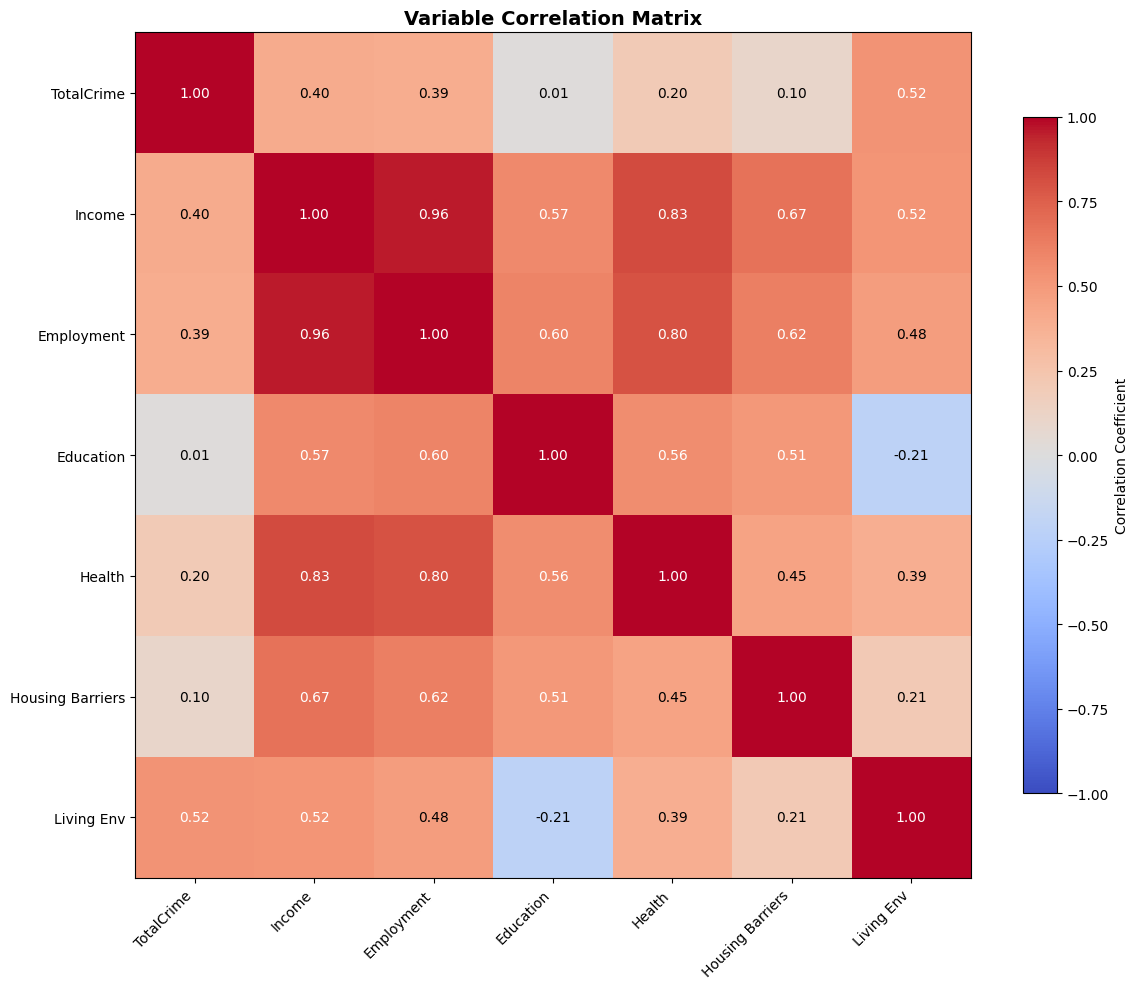


Univariate Regression Analysis Results

Income - Average score:
  Coefficient: 322,857.22
  Standard Error: 133,617.93
  t-value: 2.416
  p-value: 0.0220
  R²: 0.1629
  Adjusted R²: 0.1350

Employment - Average score:
  Coefficient: 621,884.46
  Standard Error: 267,068.39
  t-value: 2.329
  p-value: 0.0268
  R²: 0.1531
  Adjusted R²: 0.1248

Education, Skills and Training - Average score:
  Coefficient: 53.64
  Standard Error: 989.85
  t-value: 0.054
  p-value: 0.9571
  R²: 0.0001
  Adjusted R²: -0.0332

Health Deprivation and Disability - Average score:
  Coefficient: 11,932.45
  Standard Error: 10,590.41
  t-value: 1.127
  p-value: 0.2688
  R²: 0.0406
  Adjusted R²: 0.0086

Barriers to Housing and Services - Average score:
  Coefficient: 361.23
  Standard Error: 670.01
  t-value: 0.539
  p-value: 0.5938
  R²: 0.0096
  Adjusted R²: -0.0234

Living Environment - Average score:
  Coefficient: 2,040.34
  Standard Error: 605.47
  t-value: 3.370
  p-value: 0.0021
  R²: 0.2746
  Adjusted R

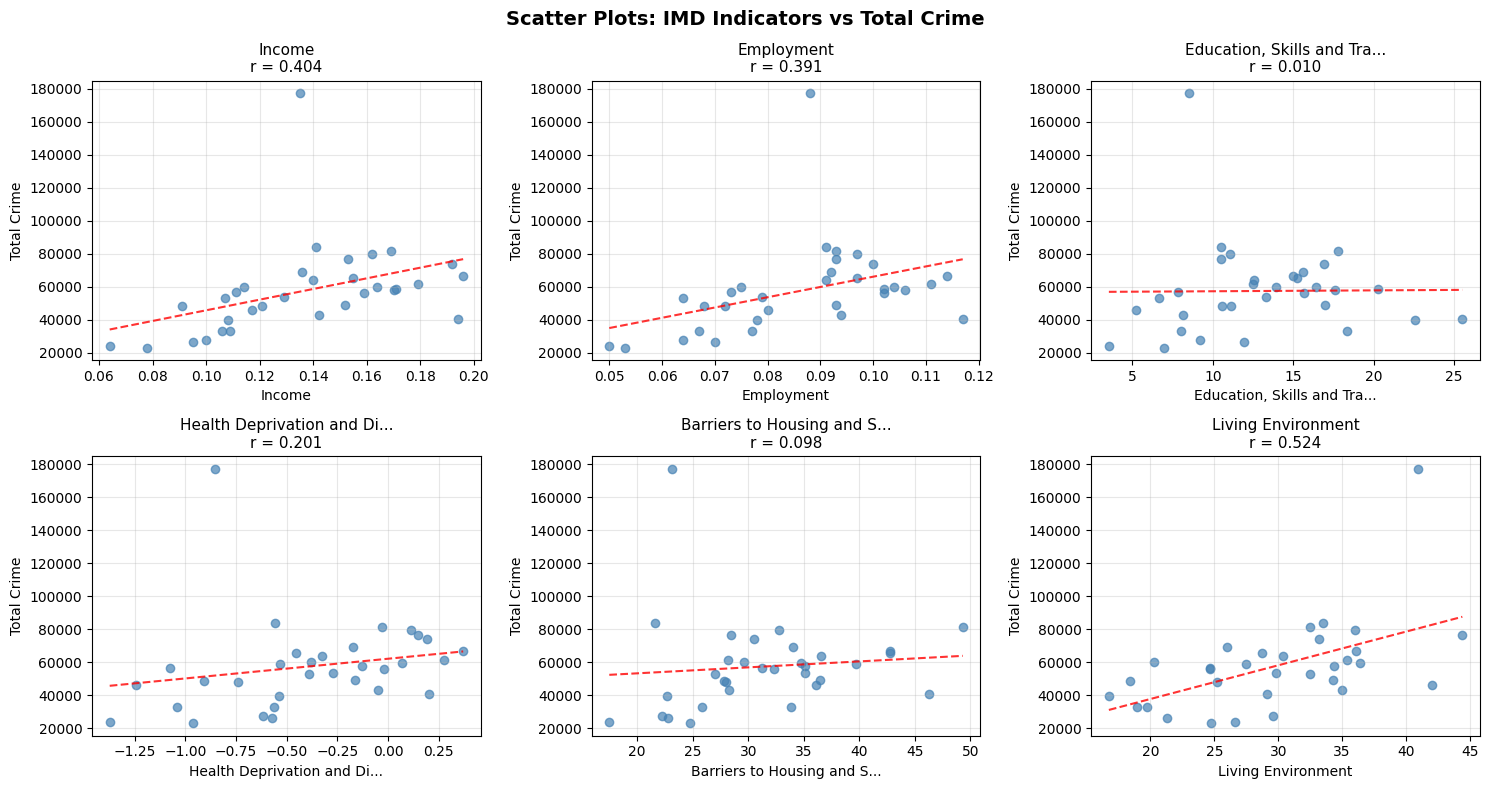

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


def load_and_prepare_data():
    # Note: Replace with your actual file paths
    crime_file = 'MPS Borough Level Crime (most recent 24 months).csv'
    imd_file = 'IMD.xlsx'

    # Read crime data
    crime_df = pd.read_csv(crime_file)
    print("Crime data loaded successfully")
    print(f"Crime data shape: {crime_df.shape}")

    # Read IMD data
    imd_df = pd.read_excel(imd_file, sheet_name=0)
    print("\nIMD data loaded successfully")
    print(f"IMD data shape: {imd_df.shape}")

    return crime_df, imd_df


def prepare_crime_data(crime_df):
    time_columns = [col for col in crime_df.columns if col.isdigit() and len(col) == 6]

    # Calculate total crimes per borough
    crime_totals = crime_df.groupby('BoroughName')[time_columns].sum().sum(axis=1).reset_index()
    crime_totals.columns = ['BoroughName', 'TotalCrime']

    # Remove excluded boroughs
    excluded_boroughs = ['London Heathrow and London City Airports', 'Unknown']
    crime_totals = crime_totals[~crime_totals['BoroughName'].isin(excluded_boroughs)]

    print(f"\nCrime data summary: {crime_totals.shape[0]} boroughs")
    return crime_totals


def prepare_imd_data(imd_df):
    imd_columns_needed = [
        'Local Authority District name (2019)',
        'Income - Average score',
        'Employment - Average score',
        'Education, Skills and Training - Average score',
        'Health Deprivation and Disability - Average score',
        'Barriers to Housing and Services - Average score',
        'Living Environment - Average score'
    ]

    imd_selected = imd_df[imd_columns_needed].copy()
    imd_selected.rename(columns={'Local Authority District name (2019)': 'Borough'}, inplace=True)

    # Remove excluded boroughs
    imd_selected = imd_selected[imd_selected['Borough'] != 'City of London']

    print(f"IMD data: {imd_selected.shape[0]} boroughs")
    return imd_selected


def merge_datasets(crime_totals, imd_selected):
    merged_df = pd.merge(crime_totals, imd_selected,
                         left_on='BoroughName', right_on='Borough',
                         how='inner')

    print(f"\nMerged data: {merged_df.shape[0]} boroughs")
    print("First 5 rows of data:")
    print(merged_df.head())

    return merged_df


def correlation_analysis(merged_df):
    correlation_data = merged_df[[
        'TotalCrime',
        'Income - Average score',
        'Employment - Average score',
        'Education, Skills and Training - Average score',
        'Health Deprivation and Disability - Average score',
        'Barriers to Housing and Services - Average score',
        'Living Environment - Average score'
    ]]

    correlation_matrix = correlation_data.corr()

    # Plot correlation matrix heatmap
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient', shrink=0.8)

    # numerical labels
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                     ha='center', va='center', fontsize=10,
                     color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')


    short_names = ['TotalCrime', 'Income', 'Employment', 'Education',
                   'Health', 'Housing Barriers', 'Living Env']

    plt.xticks(range(len(short_names)), short_names, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(short_names)), short_names, fontsize=10)
    plt.title('Variable Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return correlation_matrix


def univariate_regression_analysis(merged_df):
    imd_variables = [
        'Income - Average score',
        'Employment - Average score',
        'Education, Skills and Training - Average score',
        'Health Deprivation and Disability - Average score',
        'Barriers to Housing and Services - Average score',
        'Living Environment - Average score'
    ]

    single_var_results = {}

    print("\n" + "=" * 60)
    print("Univariate Regression Analysis Results")
    print("=" * 60)

    for var in imd_variables:
        X_single = sm.add_constant(merged_df[var])
        y_single = merged_df['TotalCrime']

        model_single = sm.OLS(y_single, X_single).fit()
        single_var_results[var] = {
            'coef': model_single.params[var],
            'std_err': model_single.bse[var],
            't_value': model_single.tvalues[var],
            'p_value': model_single.pvalues[var],
            'r_squared': model_single.rsquared,
            'adj_r_squared': model_single.rsquared_adj
        }

        # Print results
        print(f"\n{var}:")
        print(f"  Coefficient: {model_single.params[var]:,.2f}")
        print(f"  Standard Error: {model_single.bse[var]:,.2f}")
        print(f"  t-value: {model_single.tvalues[var]:.3f}")
        print(f"  p-value: {model_single.pvalues[var]:.4f}")
        print(f"  R²: {model_single.rsquared:.4f}")
        print(f"  Adjusted R²: {model_single.rsquared_adj:.4f}")

    return single_var_results, imd_variables


def multivariate_regression_analysis(merged_df, imd_variables):
    X = merged_df[imd_variables]
    y = merged_df['TotalCrime']

    # Add constant term
    X = sm.add_constant(X)

    # Perform OLS regression
    model = sm.OLS(y, X).fit()

    # Print regression results
    print("\n" + "=" * 60)
    print("Multivariate Regression Analysis Results")
    print("=" * 60)
    print(model.summary())

    return model


def calculate_vif(merged_df, imd_variables):
    vif_data = merged_df[imd_variables]
    vif_data_with_const = sm.add_constant(vif_data)

    vif_results = {}
    for i, var in enumerate(imd_variables, start=1):
        vif = variance_inflation_factor(vif_data_with_const.values, i)
        vif_results[var] = vif

    print("\n" + "=" * 40)
    print("Variance Inflation Factor (VIF) Analysis")
    print("=" * 40)
    for var, vif in vif_results.items():
        severity = "Severe" if vif >= 10 else ("Moderate" if vif >= 5 else "Low")
        print(f"{var[:30]:30s} VIF = {vif:6.2f} ({severity} multicollinearity)")

    return vif_results


def residual_analysis(model, merged_df):
    residuals = model.resid
    fitted_values = model.fittedvalues
    shapiro_stat, shapiro_p = stats.shapiro(residuals)

    return residuals, fitted_values


def create_summary_table(single_var_results, model, vif_results, imd_variables):
    summary_data = []

    for var in imd_variables:
        short_name = var.replace(' - Average score', '')
        if len(short_name) > 20:
            short_name = short_name[:20] + "..."

        # univariate results
        single_coef = single_var_results[var]['coef']
        single_p = single_var_results[var]['p_value']
        single_r2 = single_var_results[var]['r_squared']

        # multivariate results
        multi_coef = model.params[var] if var in model.params else np.nan
        multi_p = model.pvalues[var] if var in model.pvalues else np.nan

        # VIF
        vif = vif_results[var]

        summary_data.append({
            'Variable': short_name,
            'Univariate Coef': single_coef,
            'Univariate p-value': single_p,
            'Univariate R²': single_r2,
            'Multivariate Coef': multi_coef,
            'Multivariate p-value': multi_p,
            'VIF': vif
        })

    summary_df = pd.DataFrame(summary_data)

    # Format for display
    display_df = summary_df.copy()
    display_df['Univariate Coef'] = display_df['Univariate Coef'].apply(
        lambda x: f"{x:,.2f}" if abs(x) > 1000 else f"{x:.2f}")
    display_df['Univariate p-value'] = display_df['Univariate p-value'].apply(lambda x: f"{x:.4f}")
    display_df['Univariate R²'] = display_df['Univariate R²'].apply(lambda x: f"{x:.4f}")
    display_df['Multivariate Coef'] = display_df['Multivariate Coef'].apply(
        lambda x: f"{x:,.2f}" if not pd.isna(x) and abs(x) > 1000 else (
            f"{x:.2f}" if not pd.isna(x) else "N/A"))
    display_df['Multivariate p-value'] = display_df['Multivariate p-value'].apply(
        lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")
    display_df['VIF'] = display_df['VIF'].apply(lambda x: f"{x:.2f}")

    print("\n" + "=" * 80)
    print("Summary Table: IMD Indicators vs Total Crime Analysis")
    print("=" * 80)
    print(display_df.to_string(index=False))

    return summary_df


def create_scatter_plots(merged_df, imd_variables):
    n_vars = len(imd_variables)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(imd_variables):
        ax = axes[i]
        ax.scatter(merged_df[var], merged_df['TotalCrime'], alpha=0.7, color='steelblue')

        # Add regression line
        z = np.polyfit(merged_df[var], merged_df['TotalCrime'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(merged_df[var].min(), merged_df[var].max(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

        # Calculate correlation coefficient
        corr = merged_df[var].corr(merged_df['TotalCrime'])

        # Simplify variable name
        short_name = var.replace(' - Average score', '')
        if len(short_name) > 25:
            short_name = short_name[:25] + "..."

        ax.set_xlabel(short_name, fontsize=10)
        ax.set_ylabel('Total Crime', fontsize=10)
        ax.set_title(f'{short_name}\nr = {corr:.3f}', fontsize=11)
        ax.grid(True, alpha=0.3)

    # Hide extra subplots
    for i in range(n_vars, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Scatter Plots: IMD Indicators vs Total Crime', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()


def main():
    print("=" * 60)
    print("Regression Analysis: IMD Indicators vs Crime Data")
    print("=" * 60)

    # 1. Load data
    crime_df, imd_df = load_and_prepare_data()

    # 2. Prepare data
    crime_totals = prepare_crime_data(crime_df)
    imd_selected = prepare_imd_data(imd_df)

    # 3. Merge data
    merged_df = merge_datasets(crime_totals, imd_selected)

    # 4. Correlation analysis
    correlation_matrix = correlation_analysis(merged_df)

    # 5. Univariate regression analysis
    single_var_results, imd_variables = univariate_regression_analysis(merged_df)

    # 6. Multivariate regression analysis
    model = multivariate_regression_analysis(merged_df, imd_variables)

    # 7. Multicollinearity analysis
    vif_results = calculate_vif(merged_df, imd_variables)

    # 8. Create summary table
    summary_df = create_summary_table(single_var_results, model, vif_results, imd_variables)

    # 9. Create scatter plots
    create_scatter_plots(merged_df, imd_variables)

    return merged_df, model, summary_df


# Run main function
if __name__ == "__main__":
    merged_df, model, summary_df = main()